In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install ipympl 1>/dev/null
%matplotlib widget

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!pip install open3d 1>/dev/null
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import sys
import os
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

from tqdm import tqdm
import json

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud, visualize_pointcloud_patches
from models_adl4cv.patching import get_nearest_neighbors_batch_pytorch3d, generate_non_overlapping_patches, get_nearest_neighbors_batch_pytorch3d_indicies, non_overlapping_spectral_patches

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=65d6d53d5df37646cbd1e109590b9fbfd9632200edb33b671f108b1f5ff30bc9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=039635eb8ac560d05fa9b5506fd3ee082a85fe639fcc04792832edca01efa500
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
import numpy as np
from pytorch3d.ops import knn_points
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import random
import logging

In [ ]:
# !git pull

In [ ]:
NPOINTS = 2048 * 3
CATEGORY = "chair"
BATCH_SIZE = 8 * 3 # 4
PATCH_SIZE = 512

In [ ]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)


Total number of data:400
Min number of points: (train)2048 (test)2048


In [ ]:
for i in range(10):
  pc = dataset_pvd[i]['train_points']
  visualize_pointcloud(pc)

In [ ]:
INDEX = 6

In [ ]:
point_cloud = dataset_pvd[INDEX]['train_points']

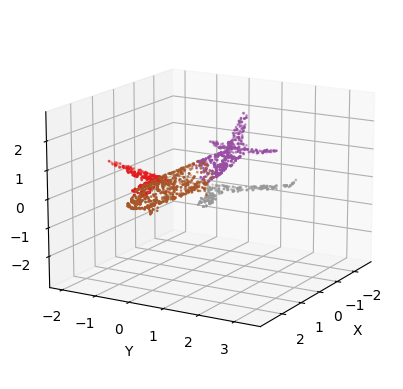

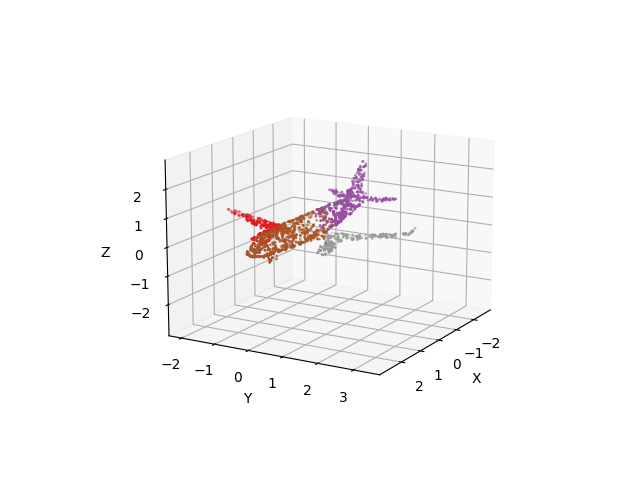

In [ ]:
patches = non_overlapping_spectral_patches(point_cloud, patch_size=PATCH_SIZE, k=64)
visualize_pointcloud_patches(patches)

In [ ]:
refined_airplanes = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/airplanes_6k.pth", map_location=torch.device('cpu'))

In [ ]:
for i in range(20):
  visualize_pointcloud_eval(dataset_pvd[i]['train_points'], refined_airplanes[i])

In [ ]:
INPUT_INDEX = 15
OUTPUT_INDEX = 3
_ = visualize_pointcloud_eval(dataset_pvd[INPUT_INDEX]['train_points'], refined_airplanes[OUTPUT_INDEX])

In [ ]:
input = dataset_pvd[INPUT_INDEX]['train_points']
output = refined_airplanes[OUTPUT_INDEX]
print(input.shape, output.shape)

torch.Size([2048, 3]) torch.Size([6144, 3])


[torch.Size([928, 3]), torch.Size([349, 3]), torch.Size([359, 3]), torch.Size([412, 3])]


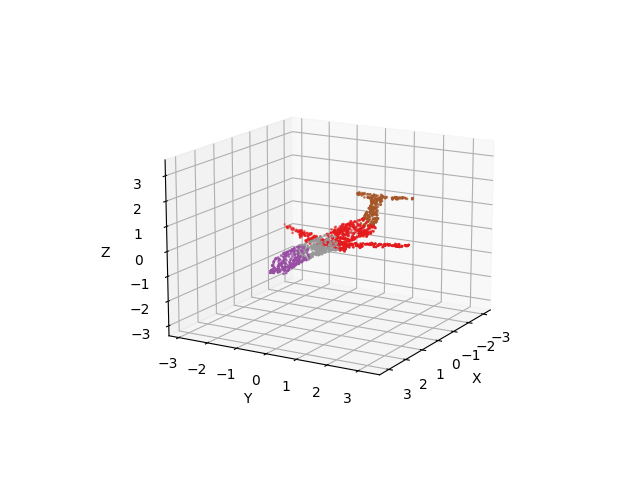

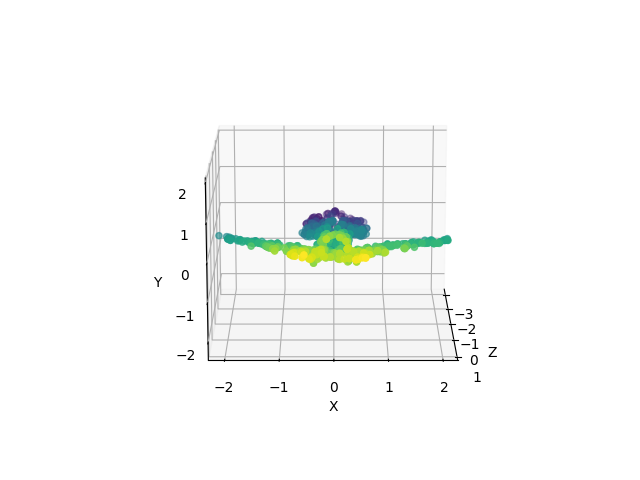

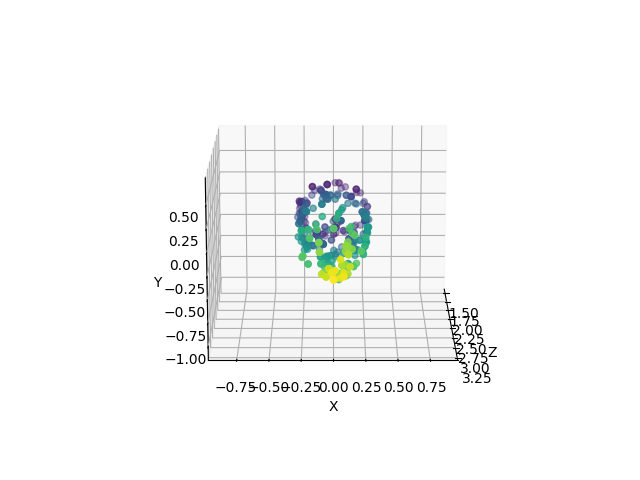

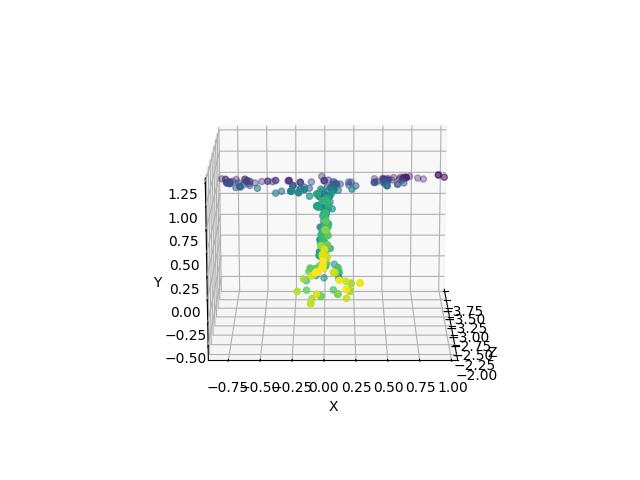

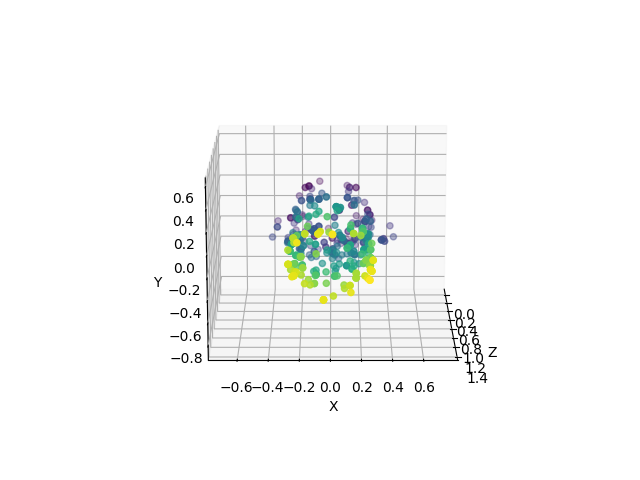

In [ ]:
patches = non_overlapping_spectral_patches(input, patch_size=PATCH_SIZE, k=256)
visualize_pointcloud_patches(patches)
print([p.shape for p in patches])
for patch in patches:
  pass
  _ = visualize_pointcloud(patch)

In [ ]:
interesting_input_patches = [patches[1], patches[2]]

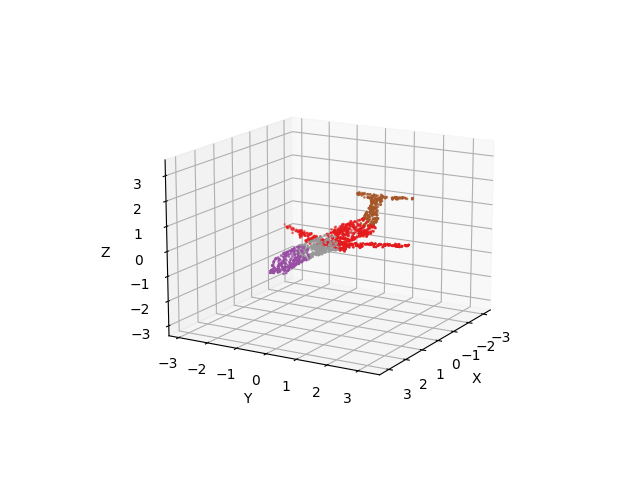

In [ ]:
_ = visualize_pointcloud_patches(patches)

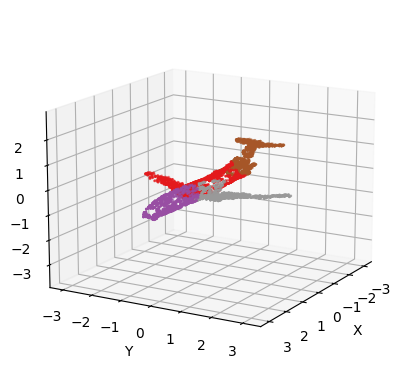

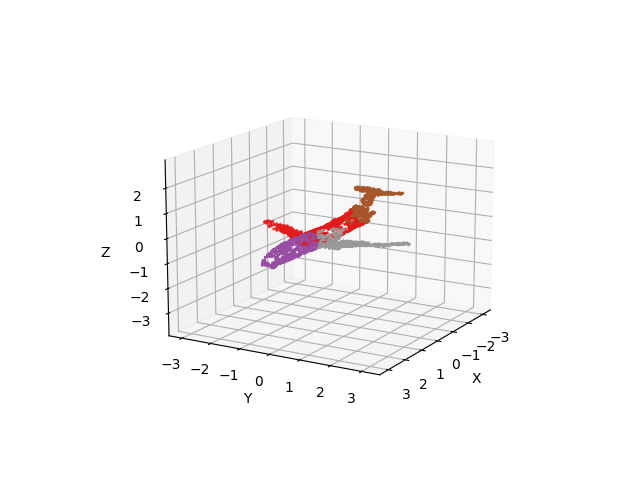

In [ ]:
output_patches = non_overlapping_spectral_patches(output, patch_size=PATCH_SIZE*3, k=769)
visualize_pointcloud_patches(output_patches)
# print([p.shape for p in patches])
# for i in range(len(patches)):
#   _ = visualize_pointcloud_eval(patches[i], output_patches[i])

In [ ]:
goutput = refined_airplanes[5]
_ = visualize_pointcloud_eval(point_cloud, output)
# for i in range(10):
  # visualize_pointcloud(refined_airplanes[i])

In [ ]:
x = torch.load("eval-results/airplanes_pvd_output.pth", map_location=torch.device('cpu'))
refined_airplanes = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/airplanes_6k.pth", map_location=torch.device('cpu'))
print(x.shape, refined_airplanes.shape)

torch.Size([400, 2048, 3]) torch.Size([400, 6144, 3])


In [ ]:
for i in range(10, 20):
  visualize_pointcloud_eval(x[i], refined_airplanes[i])

In [ ]:
INDEX = 17
_ = visualize_pointcloud_eval(x[INDEX], refined_airplanes[INDEX])
input, output = x[INDEX], refined_airplanes[INDEX]

In [ ]:
output_patches = non_overlapping_spectral_patches(output, patch_size=PATCH_SIZE*3, k=700)
visualize_pointcloud_patches(output_patches)

In [ ]:
for patch in output_patches:
  visualize_pointcloud(patch)

In [ ]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 28.12 MiB | 4.76 MiB/s, done.
From https://gitlab.lrz.de/00000000014A00FC/coarse-to-fine-shapes
   db097c0..b944224  main       -> origin/main
Updating db097c0..b944224
Fast-forward
 eval-results/airplane_6k_patches_input.pth   | Bin 0 -> 10237017 bytes
 eval-results/airplane_6k_patches_refined.pth | Bin 0 -> 29905113 bytes
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 eval-results/airplane_6k_patches_input.pth
 create mode 100644 eval-results/airplane_6k_patches_refined.pth


In [8]:
patches_input = torch.load("eval-results/airplane_6k_patches_input.pth", map_location=torch.device('cpu'))
patches_output = torch.load("eval-results/airplane_6k_patches_refined.pth", map_location=torch.device('cpu'))

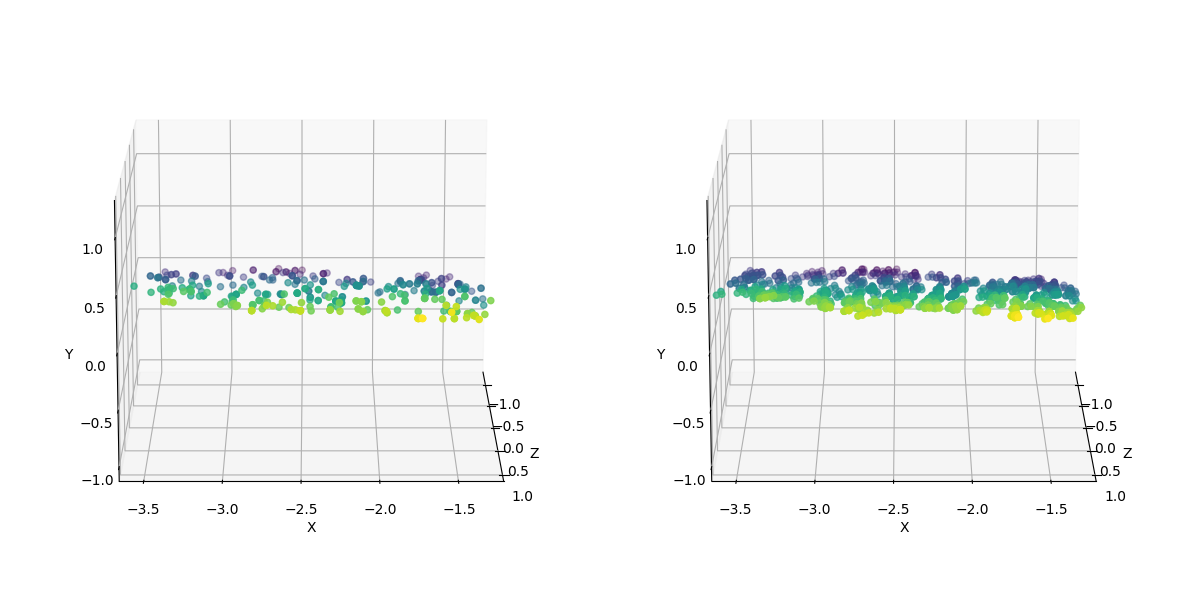

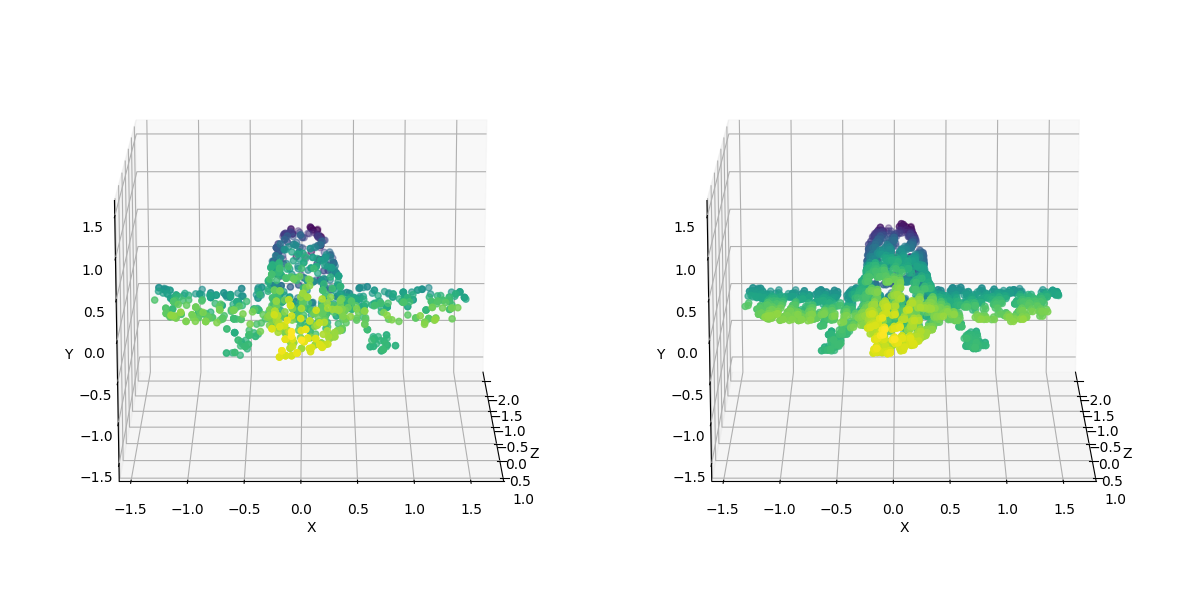

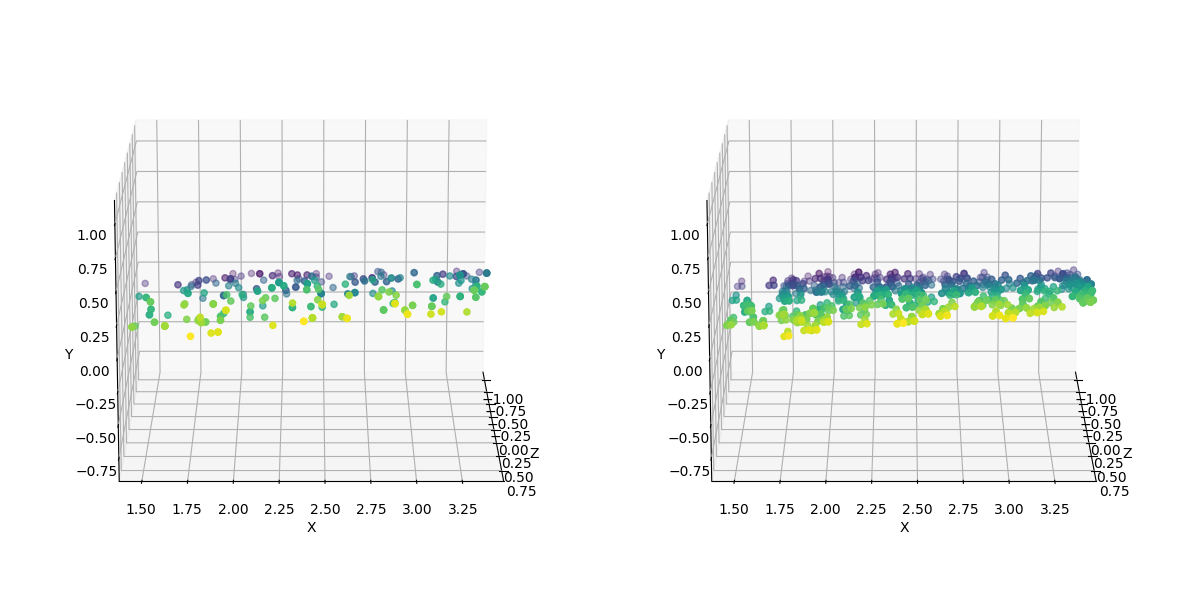

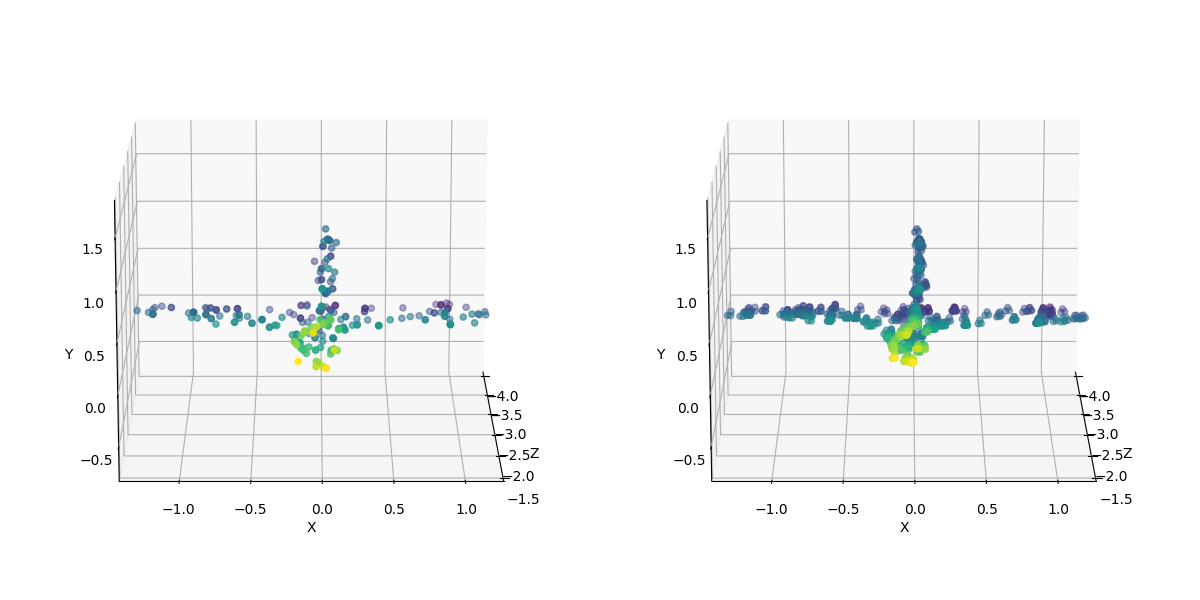

In [9]:
for i in range(4):
  visualize_pointcloud_eval(patches_input[0][0][i], patches_output[i])

In [10]:
good_input_patches = [patches_input[0][0][i] for i in [0, 3]]
good_output_patches = [patches_output[i].squeeze() for i in [0, 3]]
good_input = torch.cat([patches_input[0][0][i] for i in range(4)])
good_output = torch.cat([patches_output[i].squeeze() for i in range(4)])

In [11]:
to_plot = [*good_input_patches, *good_output_patches, good_input, good_output]

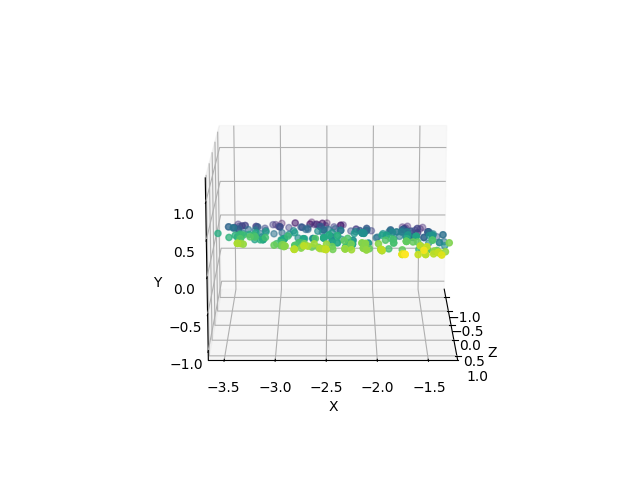

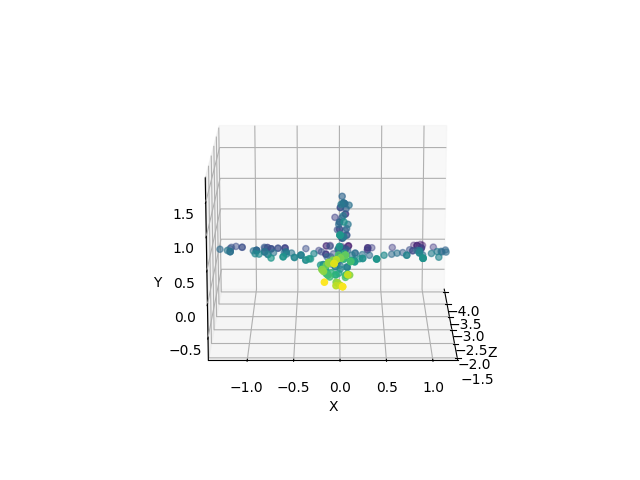

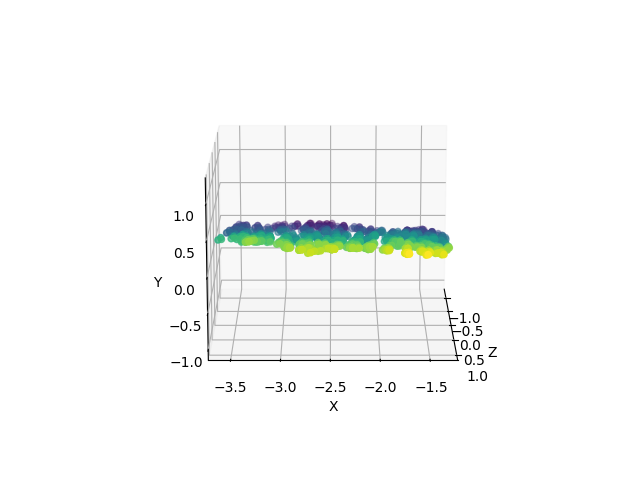

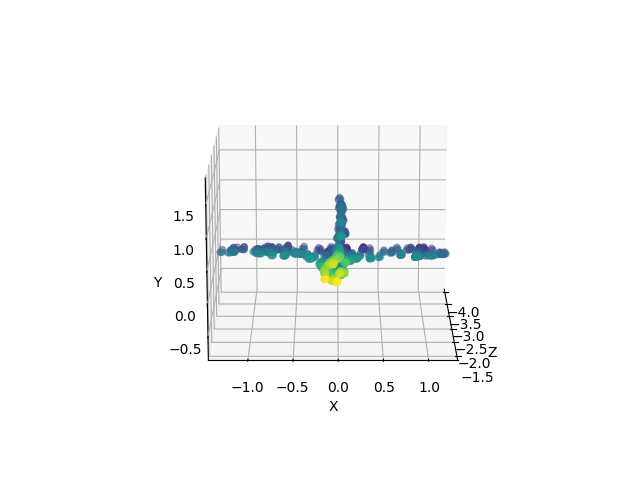

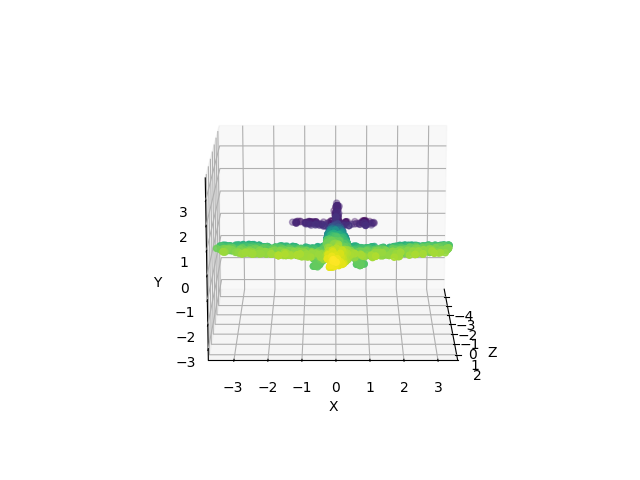

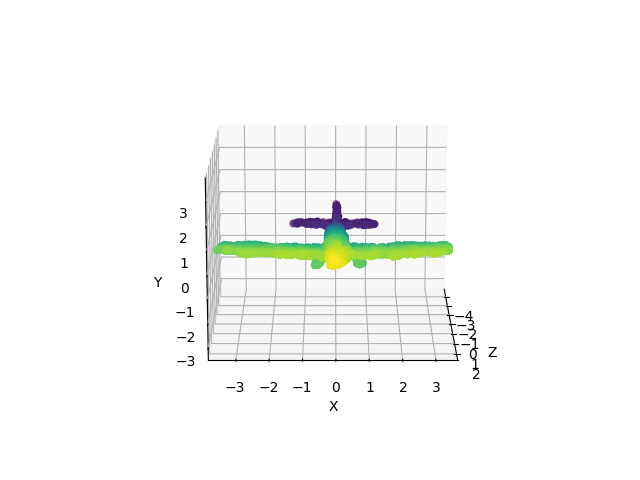

In [12]:
for p in to_plot:
  visualize_pointcloud(p)

In [13]:
path = Path("visuals/poster/inference4/")
path.mkdir(parents=True, exist_ok=True)

for index, pc in enumerate(to_plot[4:]):
  beautiful(pc, path / f"{index}")

Center: [0.0865308  0.22548494 1.1807005 ], Scale: 7.0404157638549805


Center: [0.08667028 0.24052021 1.1502926 ], Scale: 7.173540115356445


## Other

In [ ]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [ ]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048*3,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)2048 (test)5000


In [ ]:
for i in range(20, 30):
  pc = tr_dataset[i]['test_points']
  visualize_pointcloud(pc)

In [ ]:
INDEX = 21
pc = tr_dataset[INDEX]['train_points']
gt = tr_dataset[INDEX]['test_points']

In [ ]:
print(pc.shape, gt.shape)

torch.Size([2048, 3]) torch.Size([5000, 3])


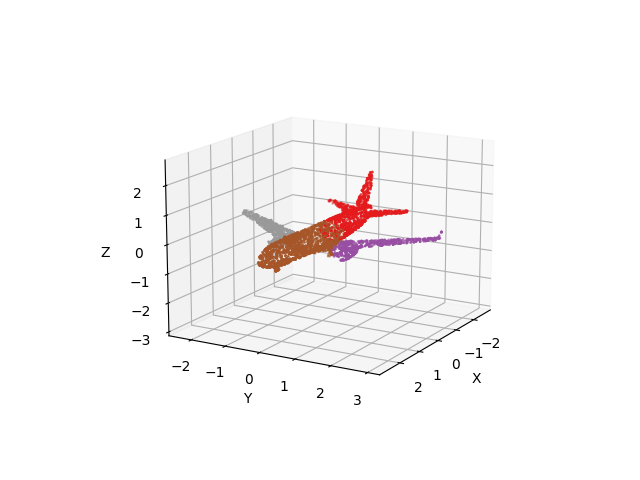

In [ ]:
# patches = non_overlapping_spectral_patches(pc, 512, k=200)
gt_patches = non_overlapping_spectral_patches(gt, 5000//4, k=300)
_ = visualize_pointcloud_patches(gt_patches)

In [ ]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[idx,:]

def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size())
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [ ]:
for patch in gt_patches:
  visualize_pointcloud(patch)

In [ ]:
to_visualize = [gt, gt_patches[0], gt_patches[3], subsample(add_random_noise(gt_patches[0], std=0.00002), 512), subsample(add_random_noise(gt_patches[3], std=0.00002), 512), subsample(add_random_noise(gt, std=0.00002), 2048)]
visualize_pointcloud_eval(to_visualize[0], to_visualize[-1])
visualize_pointcloud_eval(to_visualize[1], to_visualize[3])
visualize_pointcloud_eval(to_visualize[2], to_visualize[4])


In [ ]:
path = Path("visuals/poster/inference2")
path.mkdir(parents=True, exist_ok=True)

for index, pc in enumerate(to_visualize):
  beautiful(pc, path / f"{index}")

In [ ]:
!git pull

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), 13.91 MiB | 4.36 MiB/s, done.
From https://gitlab.lrz.de/00000000014A00FC/coarse-to-fine-shapes
   c2f1334..db097c0  main       -> origin/main
Updating c2f1334..db097c0
Fast-forward
 eval-results/airplanes_pvd_output.pth                           |   Bin 0 -> 9831147 bytes
 eval-results/chairs_pvd_output.pth                              |   Bin 0 -> 9831147 bytes
 evaluate_PVD_output.ipynb                                       |    36 +-
 input.xml                                                       | 12288 +++----
 mesh_reconstruction.ipynb                                       |   174 +-
 output.xml                                                      | 47104 +++++++++++++++++++-------
 ...-Global-Chair-Attention-Upsampler-Patch-Based-Airplane.ipynb |    26

## Mitsuba

In [6]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.7 MB/s eta 0:00:00


In [ ]:
path = Path("visuals/poster/inference/")
path.mkdir(parents=True, exist_ok=True)

In [7]:
def beautiful(point_cloud, path: str):
  assert len(point_cloud.shape) == 2
  if type(point_cloud) is torch.Tensor:
    point_cloud = point_cloud.numpy()
  if type(path) is PosixPath:
    path = str(path)
  img = render_mitsuba(point_cloud, f"{path}.xml", fov=20, n_points=point_cloud.shape[0])
  plt.axis("off")
  plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
  plt.savefig(f"{path}.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
beautiful(point_cloud, path / "pvd")

In [ ]:
for index, patch in enumerate(patches):
  print(patch)
  beautiful(patch, path / f"{index}")

In [ ]:
refined_outputs = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/surface_reconstruction.pth", map_location=torch.device('cpu'))

In [ ]:
output = refined_outputs[INDEX]

In [ ]:
visualize_pointcloud(output)

## Util

In [ ]:
def load_pts_to_tensor(filename):
    with open(filename, 'r') as file:
        points = []
        for line in file:
            x, y, z = map(float, line.strip().split())
            points.append([x, y, z])
        return torch.tensor(points, dtype=torch.float32)

In [ ]:
point_cloud = torch.load("/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44/09-input.pth", map_location=torch.device('cpu'))

In [ ]:
img = render_mitsuba(point_cloud, "./test.xml", fov=20)

plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping~

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [ ]:
!pip install mitsuba
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44


In [ ]:
point_cloud = point_cloud.numpy().squeeze()

In [ ]:
point_cloud.shape

(2048, 3)

In [ ]:
base_dir = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/2024-01-30_23-46-44"

In [ ]:
data = {i: {typ: torch.load(f"{base_dir}/{i:02d}-{typ}.pth", map_location=torch.device('cpu')).numpy().squeeze() for typ in ("input", "refined_output")} for i in range(10)}

In [ ]:
print(data)

In [ ]:
for index, results in data.items():
  for typ, point_cloud in results.items():
    plot_name = f"./pt-{index}-{typ}"
    img = render_mitsuba(point_cloud, f"{plot_name}.xml", fov=20)
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
    plt.savefig(f"{plot_name}.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
for i in range(10):
  img = render_mitsuba(point_cloud, "./test.xml", fov=20)

In [ ]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)); # approximate sRGB tonemapping
plt.savefig("test.png", bbox_inches='tight', pad_inches=0, dpi=400)

In [ ]:
plt.savefig(f"test.png", dpi=400)